In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal

from shapely.geometry import Point

## Emplacement des stations

In [2]:
fleuve = "Loire"

tableau_stations_file = "../../Data/Extraction_Hydro/" + fleuve + "/Stations.csv"
tableau_stations = pd.read_csv(tableau_stations_file, encoding="UTF-8",
                              delimiter=";")
tableau_stations = gpd.GeoDataFrame(tableau_stations)
n_stations = tableau_stations.shape[0]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [3]:
tableau_stations['geometry'] = tableau_stations.apply(lambda x: Point(float(x['X (m)']), float(x['Y (m)'])), axis = 1)
tableau_stations = tableau_stations.set_crs('EPSG:27572')
tableau_stations = tableau_stations.to_crs(world.crs)
tableau_stations

,Code station,Libelle station,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,Regime influencé,Altitude du zéro de l'échelle,Coordonnées,X (m),Y (m),geometry
0,K0030020,La Loire à Issarlès [Pont de La Borie],True,True,True,True,True,True,True,True,True,True,True,fortement,881.34,Lambert II Étendu,735456,1981360,POINT (4.04849 44.81973)
1,K0100020,La Loire à Goudet,True,True,True,True,True,True,True,True,True,True,True,fortement,0.00,Lambert II Étendu,725285,1988855,POINT (3.92189 44.88905)
2,K0120020,La Loire à Coubon,True,True,True,True,True,True,True,False,False,False,False,fortement,NaN,Lambert II Étendu,724738,2000928,POINT (3.91804 44.99772)
3,K0260020,La Loire à Chadrac [Pont du Monteil à Chadrac],True,True,True,True,True,True,True,True,True,True,True,fortement en étiage,589.50,Lambert II Étendu,723451,2008712,POINT (3.90369 45.06796)
4,K0550010,La Loire à Bas-en-Basset,True,True,True,True,True,True,True,True,True,True,True,fortement,442.00,Lambert II Étendu,739757,2034330,POINT (4.11799 45.29523)
5,K0690010,La Loire à Montrond-les-Bains,True,True,True,True,True,True,True,True,True,True,True,fortement,339.11,Lambert II Étendu,747249,2073210,POINT (4.22536 45.64333)
6,K0910010,La Loire à Villerest,True,True,True,True,True,True,True,True,True,True,True,fortement en étiage,268.51,Lambert II Étendu,732250,2113011,POINT (4.04411 46.00441)
7,K0910050,La Loire à Villerest [Pont de Villerest],True,True,True,True,True,True,True,True,True,True,True,fortement,267.51,Lambert II Étendu,732434,2112065,POINT (4.04622 45.99586)
8,K1180010,La Loire à Digoin,True,True,True,True,True,True,True,True,True,True,True,fortement,224.19,Lambert II Étendu,726418,2165557,POINT (3.98303 46.47817)
9,K1440010,La Loire à Gilly-sur-Loire,True,True,True,True,True,True,True,True,True,True,True,fortement,209.61,Lambert II Étendu,709637,2171929,POINT (3.76603 46.53844)


<AxesSubplot:>

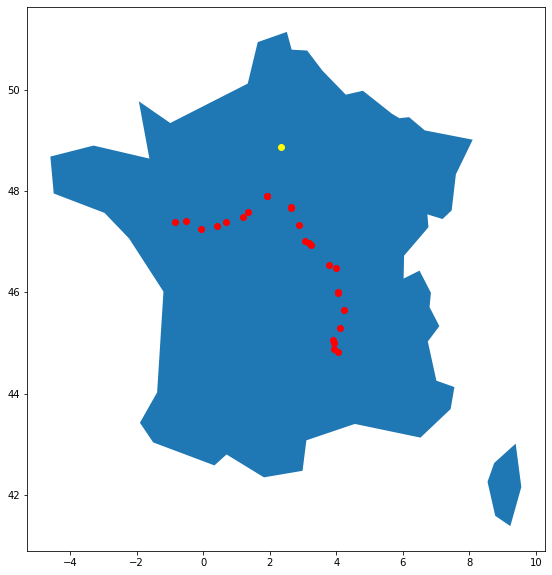

In [4]:
france = world[world['name'] == "France"].geometry.explode().values[[1,2]].unary_union()

base = gpd.GeoSeries(france).plot(figsize = (10, 10))
tableau_stations.plot(ax = base, color = "red")
cities[cities['name'] == "Paris"].plot(ax = base, color = "yellow")

On trie:
- Du sur au Nord pour les station où la longitude est supérieure à 2
- Puis Est à Ouest.

In [5]:
tableau_stations["Ord"] = tableau_stations["geometry"].apply(lambda x: x.coords[:][0][1])
tableau_stations["Abs"] = tableau_stations["geometry"].apply(lambda x: x.coords[:][0][0])

In [6]:
tableau_stations_Est = tableau_stations[tableau_stations["Abs"] >= 2]
tableau_stations_Ouest = tableau_stations[tableau_stations["Abs"] < 2]

In [7]:
tri_Est = tableau_stations_Est.sort_values(by = "Ord", ascending=True)
tri_Ouest = tableau_stations_Ouest.sort_values(by = "Abs", ascending=False)

tableau_stations = pd.concat([tri_Est, tri_Ouest])
tableau_stations["Ordre"] = [i for i in range(n_stations)]

station_amont_pt = tableau_stations["geometry"].to_crs("EPSG:32633")[tableau_stations["Ordre"].values.argmin()]
tableau_stations["Distance amont"] = tableau_stations["geometry"].to_crs("EPSG:32633").distance(station_amont_pt)
tableau_stations

,Code station,Libelle station,2010,2011,2012,2013,2014,2015,2016,2017,...,Regime influencé,Altitude du zéro de l'échelle,Coordonnées,X (m),Y (m),geometry,Ord,Abs,Ordre,Distance amont
0,K0030020,La Loire à Issarlès [Pont de La Borie],True,True,True,True,True,True,True,True,...,fortement,881.34,Lambert II Étendu,735456,1981360,POINT (4.04849 44.81973),44.819732,4.048486,0,0.000000
1,K0100020,La Loire à Goudet,True,True,True,True,True,True,True,True,...,fortement,0.00,Lambert II Étendu,725285,1988855,POINT (3.92189 44.88905),44.889049,3.921888,1,12741.284459
2,K0120020,La Loire à Coubon,True,True,True,True,True,True,True,False,...,fortement,NaN,Lambert II Étendu,724738,2000928,POINT (3.91804 44.99772),44.997721,3.918041,2,22500.408822
3,K0260020,La Loire à Chadrac [Pont du Monteil à Chadrac],True,True,True,True,True,True,True,True,...,fortement en étiage,589.50,Lambert II Étendu,723451,2008712,POINT (3.90369 45.06796),45.067956,3.903694,3,30124.723011
4,K0550010,La Loire à Bas-en-Basset,True,True,True,True,True,True,True,True,...,fortement,442.00,Lambert II Étendu,739757,2034330,POINT (4.11799 45.29523),45.295229,4.117990,4,53588.132038
5,K0690010,La Loire à Montrond-les-Bains,True,True,True,True,True,True,True,True,...,fortement,339.11,Lambert II Étendu,747249,2073210,POINT (4.22536 45.64333),45.643333,4.225356,5,93371.515460
7,K0910050,La Loire à Villerest [Pont de Villerest],True,True,True,True,True,True,True,True,...,fortement,267.51,Lambert II Étendu,732434,2112065,POINT (4.04622 45.99586),45.995861,4.046217,6,131844.361536
6,K0910010,La Loire à Villerest,True,True,True,True,True,True,True,True,...,fortement en étiage,268.51,Lambert II Étendu,732250,2113011,POINT (4.04411 46.00441),46.004406,4.044108,7,132802.733417
8,K1180010,La Loire à Digoin,True,True,True,True,True,True,True,True,...,fortement,224.19,Lambert II Étendu,726418,2165557,POINT (3.98303 46.47817),46.478171,3.983034,8,185985.280862
9,K1440010,La Loire à Gilly-sur-Loire,True,True,True,True,True,True,True,True,...,fortement,209.61,Lambert II Étendu,709637,2171929,POINT (3.76603 46.53844),46.538441,3.766035,9,193977.162365


<AxesSubplot:>

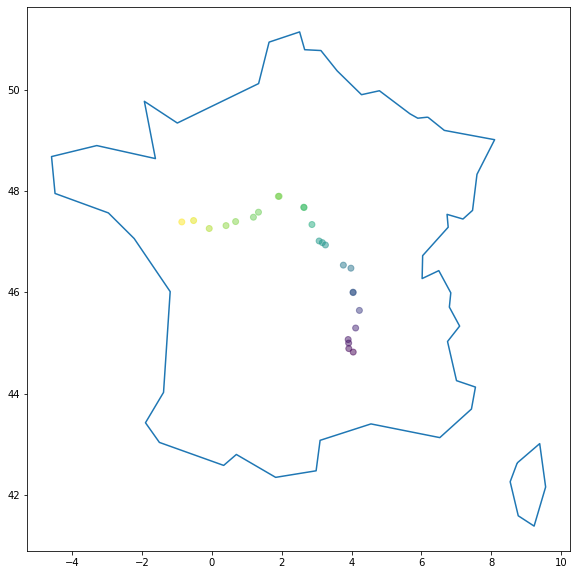

In [8]:
base = gpd.GeoSeries(france).boundary.plot(figsize = (10, 10))
dist_aval = tableau_stations["Distance amont"].values.max()
tableau_stations.plot(ax = base, color = cm.get_cmap("viridis")(tableau_stations["Distance amont"]/dist_aval), alpha = 0.5)

## On rassemble les années

In [9]:
# Initialisation
annees = [a for a in range(2010, 2021)]

for c_annee in annees:
    print(c_annee)
    
    station_dates = tableau_stations["Code station"][tableau_stations[str(c_annee)]].values[0] #Une station avec cette annee présente
    mesures_annee = pd.read_csv("../../Data/Extraction_Hydro/" + fleuve + "/" + station_dates + "_" + str(c_annee) + ".csv",
                                sep = ";")[["Date"]]
    
    for i in range(n_stations):
        code = tableau_stations[tableau_stations["Ordre"] == i]["Code station"].values[0]
        if tableau_stations[tableau_stations["Ordre"] == i][str(c_annee)].values[0]:
            station = pd.read_csv("../../Data/Extraction_Hydro/" + fleuve +"/" + code + "_" + str(c_annee) + ".csv",
                                  sep = ";")
            station = station.rename(columns = {"Q (m3/s)": code})
            mesures_annee = mesures_annee.merge(station[["Date", code]],
                                                on = "Date",
                                                how = "outer")
        else:
            mesures_annee[code] = None
    
    mesures_annee["Date"] = pd.to_datetime(mesures_annee["Date"], format = "%d/%m/%Y %H:%M")
    mesures_annee = mesures_annee.sort_values(by = "Date")
    mesures_annee.to_csv("../../Data/Extraction_Hydro/" + fleuve + "/Mesures_" + str(c_annee) + ".csv",
                        index = False)

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [10]:
mesures = pd.read_csv("../../Data/Extraction_Hydro/" + fleuve + "/Mesures_2010.csv")
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%Y/%m/%d %H:%M:%S")

for c_annee in annees[1:]:
    print(c_annee)
    mesures_annee = pd.read_csv("../../Data/Extraction_Hydro/" + fleuve + "/Mesures_" + str(c_annee) + ".csv")
    mesures_annee["Date"] = pd.to_datetime(mesures_annee["Date"], format = "%Y/%m/%d %H:%M:%S")
    mesures = pd.concat([mesures, mesures_annee])
mesures = mesures.sort_values(by = "Date")
mesures.to_csv("../../Data/Extraction_Hydro/" + fleuve + "/Mesures.csv",
                        index = False)

2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [11]:
mesures.head()

,Date,K0030020,K0100020,K0120020,K0260020,K0550010,K0690010,K0910050,K0910010,K1180010,...,K4180010,K4350020,K4350010,K4470010,K4800010,K4900030,K6830020,L8000020,L8700010,M5300010
0,2010-01-01 00:00:00,0.42,2.87,4.03,9.33,22.8,6.90,13.6,12.6,75.4,...,409.0,320.0,321.0,333.0,326.0,342.0,421.0,1150.0,1090.0,1510.0
1,2010-01-01 02:00:00,0.44,2.86,4.22,9.93,21.6,7.01,13.6,12.6,74.8,...,426.0,326.0,329.0,337.0,328.0,343.0,423.0,1150.0,1110.0,1530.0
2,2010-01-01 04:00:00,0.50,2.84,4.68,10.80,21.9,7.03,13.6,12.6,74.0,...,443.0,335.0,338.0,341.0,332.0,344.0,420.0,1150.0,1140.0,1550.0
3,2010-01-01 06:00:00,0.54,2.90,4.58,10.20,20.8,7.04,13.6,12.6,73.1,...,455.0,345.0,349.0,344.0,334.0,346.0,420.0,1150.0,1160.0,1560.0
4,2010-01-01 08:00:00,0.54,3.04,5.09,10.70,21.4,7.12,13.5,12.6,70.6,...,466.0,357.0,363.0,348.0,338.0,348.0,423.0,1140.0,1170.0,1580.0


## Explorations

In [12]:
mesures = pd.read_csv("../../Data/Extraction_Hydro/" + fleuve + "/Mesures.csv")
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures.describe(include = "all")

C:\Users\zhouj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,K0030020,K0100020,K0120020,K0260020,K0550010,K0690010,K0910050,K0910010,K1180010,...,K4180010,K4350020,K4350010,K4470010,K4800010,K4900030,K6830020,L8000020,L8700010,M5300010
count,48216,48216.000000,48216.000000,30587.000000,48216.000000,48216.000000,48216.000000,48216.000000,48216.000000,47935.00000,...,48216.000000,48216.000000,47612.000000,44405.000000,47954.000000,48128.000000,48202.000000,48216.000000,5579.000000,48216.000000
unique,48216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.585426,4.571423,7.574371,12.413882,30.614358,40.887903,54.002663,53.835507,76.45652,...,285.790372,279.733727,281.308987,321.831591,315.153706,322.135146,394.856377,587.266069,642.036028,729.350782
std,NaN,7.114918,10.588579,14.305568,20.742800,38.891062,47.558103,59.192790,59.528170,78.72845,...,258.137721,266.624259,263.499141,276.144889,279.264054,282.050312,353.454326,532.246430,367.921021,653.561272
min,NaN,0.020000,0.550000,1.330000,0.450000,1.550000,2.400000,11.000000,10.400000,11.10000,...,43.500000,26.600000,27.300000,46.700000,45.700000,48.400000,53.500000,79.600000,148.000000,96.800000
25%,NaN,0.640000,1.750000,2.840000,4.390000,10.200000,8.160000,15.500000,15.500000,22.90000,...,94.900000,82.900000,84.200000,116.000000,109.000000,114.000000,134.000000,195.000000,357.000000,234.000000


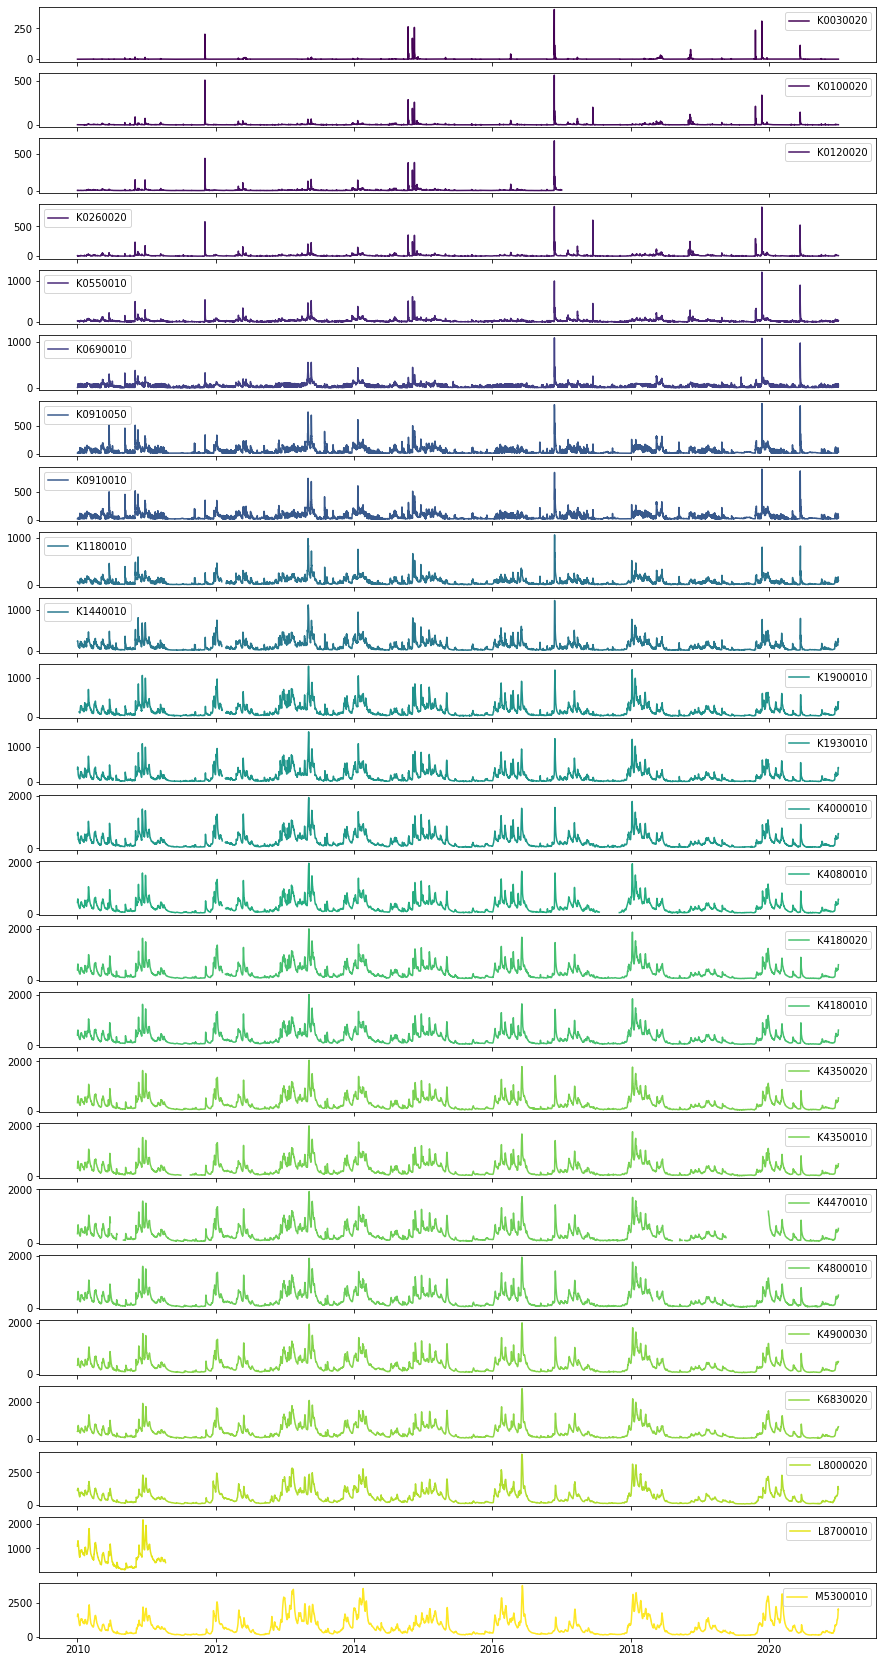

In [13]:
n_stations = tableau_stations.shape[0]
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = tableau_stations[tableau_stations["Ordre"] == i]["Code station"].values[0]
    axs[i].plot(mesures["Date"], mesures[code], label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval))
    axs[i].legend()

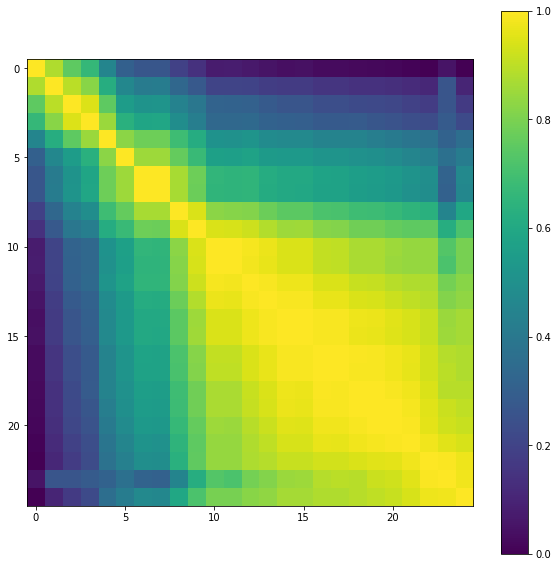

In [14]:
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures.corr())
fig.colorbar(im)

## Nettoyage

In [15]:
mesures.describe(include = "all")

C:\Users\zhouj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,Date,K0030020,K0100020,K0120020,K0260020,K0550010,K0690010,K0910050,K0910010,K1180010,...,K4180010,K4350020,K4350010,K4470010,K4800010,K4900030,K6830020,L8000020,L8700010,M5300010
count,48216,48216.000000,48216.000000,30587.000000,48216.000000,48216.000000,48216.000000,48216.000000,48216.000000,47935.00000,...,48216.000000,48216.000000,47612.000000,44405.000000,47954.000000,48128.000000,48202.000000,48216.000000,5579.000000,48216.000000
unique,48216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.585426,4.571423,7.574371,12.413882,30.614358,40.887903,54.002663,53.835507,76.45652,...,285.790372,279.733727,281.308987,321.831591,315.153706,322.135146,394.856377,587.266069,642.036028,729.350782
std,NaN,7.114918,10.588579,14.305568,20.742800,38.891062,47.558103,59.192790,59.528170,78.72845,...,258.137721,266.624259,263.499141,276.144889,279.264054,282.050312,353.454326,532.246430,367.921021,653.561272
min,NaN,0.020000,0.550000,1.330000,0.450000,1.550000,2.400000,11.000000,10.400000,11.10000,...,43.500000,26.600000,27.300000,46.700000,45.700000,48.400000,53.500000,79.600000,148.000000,96.800000
25%,NaN,0.640000,1.750000,2.840000,4.390000,10.200000,8.160000,15.500000,15.500000,22.90000,...,94.900000,82.900000,84.200000,116.000000,109.000000,114.000000,134.000000,195.000000,357.000000,234.000000


A priori, on garde les stations avec les mesures complètes

In [16]:
proportion_mesures = mesures.drop("Date", axis = 1).count()/len(mesures)
proportion_mesures

K0030020    1.000000
K0100020    1.000000
K0120020    0.634374
K0260020    1.000000
K0550010    1.000000
K0690010    1.000000
K0910050    1.000000
K0910010    1.000000
K1180010    0.994172
K1440010    0.994628
K1900010    0.993073
K1930010    0.991891
K4000010    0.996039
K4080010    0.968973
K4180020    0.996184
K4180010    1.000000
K4350020    1.000000
K4350010    0.987473
K4470010    0.920960
K4800010    0.994566
K4900030    0.998175
K6830020    0.999710
L8000020    1.000000
L8700010    0.115708
M5300010    1.000000
dtype: float64

In [17]:
stations_complet = []
stations_incomplet = []
for idx, row in proportion_mesures.iteritems():
    if row < 1:
        stations_incomplet.append(idx)
    else:
        stations_complet.append(idx)
stations_incomplet

['K0120020',
 'K1180010',
 'K1440010',
 'K1900010',
 'K1930010',
 'K4000010',
 'K4080010',
 'K4180020',
 'K4350010',
 'K4470010',
 'K4800010',
 'K4900030',
 'K6830020',
 'L8700010']

In [18]:
proportion_mesures[stations_incomplet]

K0120020    0.634374
K1180010    0.994172
K1440010    0.994628
K1900010    0.993073
K1930010    0.991891
K4000010    0.996039
K4080010    0.968973
K4180020    0.996184
K4350010    0.987473
K4470010    0.920960
K4800010    0.994566
K4900030    0.998175
K6830020    0.999710
L8700010    0.115708
dtype: float64

In [19]:
mesures[["Date"] + stations_incomplet]

,Date,K0120020,K1180010,K1440010,K1900010,K1930010,K4000010,K4080010,K4180020,K4350010,K4470010,K4800010,K4900030,K6830020,L8700010
0,2010-01-01 00:00:00,4.03,75.4,240.0,NaN,364.0,516.0,449.0,385.0,321.0,333.0,326.0,342.0,421.0,1090.0
1,2010-01-01 02:00:00,4.22,74.8,242.0,NaN,374.0,528.0,462.0,402.0,329.0,337.0,328.0,343.0,423.0,1110.0
2,2010-01-01 04:00:00,4.68,74.0,244.0,NaN,384.0,539.0,472.0,419.0,338.0,341.0,332.0,344.0,420.0,1140.0
3,2010-01-01 06:00:00,4.58,73.1,245.0,NaN,392.0,550.0,483.0,436.0,349.0,344.0,334.0,346.0,420.0,1160.0
4,2010-01-01 08:00:00,5.09,70.6,246.0,NaN,400.0,559.0,492.0,451.0,363.0,348.0,338.0,348.0,423.0,1170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48211,2020-12-31 14:00:00,NaN,94.2,244.0,388.0,412.0,555.0,580.0,566.0,475.0,496.0,471.0,471.0,665.0,NaN
48212,2020-12-31 16:00:00,NaN,93.1,240.0,387.0,410.0,554.0,579.0,573.0,482.0,504.0,478.0,472.0,667.0,NaN
48213,2020-12-31 18:00:00,NaN,92.2,235.0,386.0,409.0,553.0,578.0,581.0,490.0,512.0,485.0,475.0,670.0,NaN
48214,2020-12-31 20:00:00,NaN,92.1,231.0,385.0,409.0,553.0,577.0,586.0,493.0,522.0,493.0,479.0,672.0,NaN


In [20]:
mesures[stations_incomplet].isna().sum()

K0120020    17629
K1180010      281
K1440010      259
K1900010      334
K1930010      391
K4000010      191
K4080010     1496
K4180020      184
K4350010      604
K4470010     3811
K4800010      262
K4900030       88
K6830020       14
L8700010    42637
dtype: int64

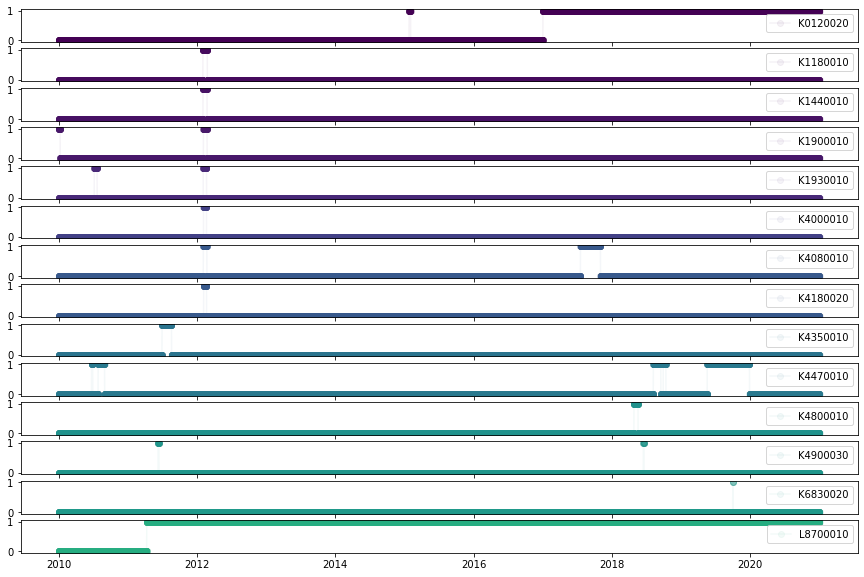

In [21]:
fig, axs = plt.subplots(len(stations_incomplet), 1, figsize = (15,10), sharex=True)
for i in range(len(stations_incomplet)):
    code = stations_incomplet[i]
    axs[i].plot(mesures["Date"], np.isnan(mesures[code]), label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval), marker = "o", alpha = 0.05)
    axs[i].legend()

On va garder les stations:
- K6830020 

In [22]:
stations_interpoler = ["K6830020"]

In [23]:
mesures[["Date"] + stations_interpoler]

,Date,K6830020
0,2010-01-01 00:00:00,421.0
1,2010-01-01 02:00:00,423.0
2,2010-01-01 04:00:00,420.0
3,2010-01-01 06:00:00,420.0
4,2010-01-01 08:00:00,423.0
...,...,...
48211,2020-12-31 14:00:00,665.0
48212,2020-12-31 16:00:00,667.0
48213,2020-12-31 18:00:00,670.0
48214,2020-12-31 20:00:00,672.0


In [24]:
for code in stations_interpoler:
    mesures[code] = mesures[code].interpolate()

Les stations au total.

In [25]:
stations_garder = stations_complet + stations_interpoler
stations_garder

['K0030020',
 'K0100020',
 'K0260020',
 'K0550010',
 'K0690010',
 'K0910050',
 'K0910010',
 'K4180010',
 'K4350020',
 'L8000020',
 'M5300010',
 'K6830020']

In [26]:
tableau_garder = tableau_stations[tableau_stations["Code station"] == stations_garder[0]]
for code in stations_garder[1:]:
    tableau_garder = pd.concat([tableau_garder, tableau_stations[tableau_stations["Code station"] == code]])

# On remet dans l'ordre et garde les colonnes importantes
tableau_garder = tableau_garder.sort_values(by = "Ordre")
tableau_garder["Ordre"] = [i for i in range(tableau_garder.shape[0])]

tableau_garder = tableau_garder[["Code station", "Libelle station", "Regime influencé", "Altitude du zéro de l'échelle", "geometry", "Ordre", ]]
tableau_garder

,Code station,Libelle station,Regime influencé,Altitude du zéro de l'échelle,geometry,Ordre
0,K0030020,La Loire à Issarlès [Pont de La Borie],fortement,881.34,POINT (4.04849 44.81973),0
1,K0100020,La Loire à Goudet,fortement,0.00,POINT (3.92189 44.88905),1
3,K0260020,La Loire à Chadrac [Pont du Monteil à Chadrac],fortement en étiage,589.50,POINT (3.90369 45.06796),2
4,K0550010,La Loire à Bas-en-Basset,fortement,442.00,POINT (4.11799 45.29523),3
5,K0690010,La Loire à Montrond-les-Bains,fortement,339.11,POINT (4.22536 45.64333),4
7,K0910050,La Loire à Villerest [Pont de Villerest],fortement,267.51,POINT (4.04622 45.99586),5
6,K0910010,La Loire à Villerest,fortement en étiage,268.51,POINT (4.04411 46.00441),6
14,K4180010,La Loire à Gien,fortement,120.97,POINT (2.63180 47.68365),7
17,K4350020,La Loire à Orléans [Quai du Roi],fortement en étiage,89.82,POINT (1.92602 47.89988),8
21,K6830020,La Loire à Langeais,fortement,34.51,POINT (0.40531 47.31986),9


On a 2 stations qui sont à peu pres les mêmes, K0910050 et K0910010.

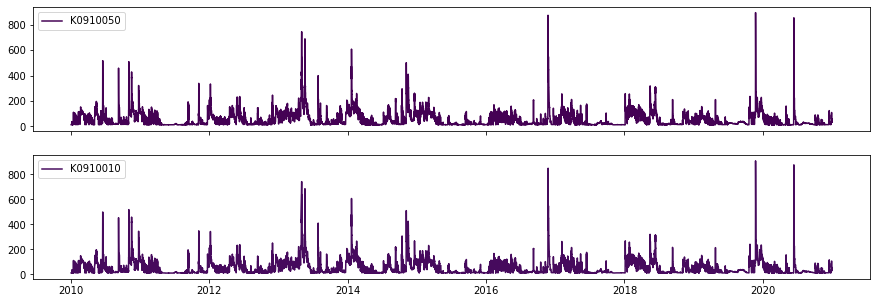

In [27]:
fig, axs = plt.subplots(2, 1, figsize = (15,5), sharex=True)
for i in range(2):
    code = ["K0910050", "K0910010"][i]
    axs[i].plot(mesures["Date"], mesures[code], label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval))
    axs[i].legend()

Au pif on garde la première "K0910050" et on enlève "K0910010".

In [28]:
stations_garder.remove("K0910010")
tableau_garder = tableau_stations[tableau_stations["Code station"] == stations_garder[0]]
for code in stations_garder[1:]:
    tableau_garder = pd.concat([tableau_garder, tableau_stations[tableau_stations["Code station"] == code]])

# On remet dans l'ordre et garde les colonnes importantes
tableau_garder = tableau_garder.sort_values(by = "Ordre")
tableau_garder["Ordre"] = [i for i in range(tableau_garder.shape[0])]

tableau_garder = tableau_garder[["Code station", "Libelle station", "Regime influencé", "Altitude du zéro de l'échelle", "geometry", "Ordre", ]]
tableau_garder

,Code station,Libelle station,Regime influencé,Altitude du zéro de l'échelle,geometry,Ordre
0,K0030020,La Loire à Issarlès [Pont de La Borie],fortement,881.34,POINT (4.04849 44.81973),0
1,K0100020,La Loire à Goudet,fortement,0.00,POINT (3.92189 44.88905),1
3,K0260020,La Loire à Chadrac [Pont du Monteil à Chadrac],fortement en étiage,589.50,POINT (3.90369 45.06796),2
4,K0550010,La Loire à Bas-en-Basset,fortement,442.00,POINT (4.11799 45.29523),3
5,K0690010,La Loire à Montrond-les-Bains,fortement,339.11,POINT (4.22536 45.64333),4
7,K0910050,La Loire à Villerest [Pont de Villerest],fortement,267.51,POINT (4.04622 45.99586),5
14,K4180010,La Loire à Gien,fortement,120.97,POINT (2.63180 47.68365),6
17,K4350020,La Loire à Orléans [Quai du Roi],fortement en étiage,89.82,POINT (1.92602 47.89988),7
21,K6830020,La Loire à Langeais,fortement,34.51,POINT (0.40531 47.31986),8
22,L8000020,La Loire à Saumur,pas ou faiblement,24.12,POINT (-0.07544 47.26242),9


<AxesSubplot:>

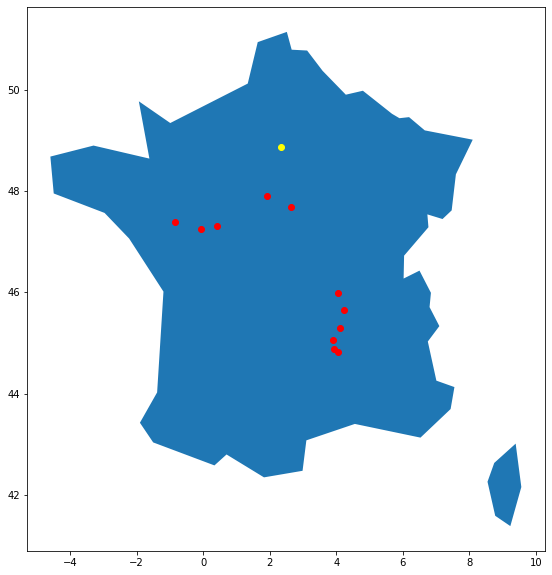

In [29]:
base = gpd.GeoSeries(france).plot(figsize = (10, 10))
tableau_garder.plot(ax = base, color = "red")
cities[cities['name'] == "Paris"].plot(ax = base, color = "yellow")

In [30]:
tableau_garder.to_csv("../../Data/Extraction_Hydro/Stations_" + fleuve + ".csv",
                        index = False)

In [31]:
mesures_garder = mesures[["Date"] + list(tableau_garder["Code station"])]
mesures_garder.to_csv("../../Data/Extraction_Hydro/Mesures_" + fleuve + ".csv",
                        index = False)